In [1]:
import numpy as np
import matplotlib.pyplot as plt

We will attempt to model the stability of a system like [HR 8799](https://en.wikipedia.org/wiki/HR_8799).  A recent investigation of this system was done in [Götberg et al. 2016](https://www.aanda.org/articles/aa/full_html/2016/08/aa26309-15/aa26309-15.html) which found many configurations are unstable to the estimated age of this explanetary system.

Close encounters can be problematic.  One approach is to switch from using a sympletic integrator to a high-order time-adaptive integrator with error-control once two planets become closer than a few Hill radii (see, e.g., [Chatterjee et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...686..580C/abstract)).

In [2]:
class State:
    """a container to hold an object"""

    def __init__(self, mass, x, y, u, v):
        self.mass = mass
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __str__(self):
        return f"{self.mass:10.6f}: {self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

In [3]:
import collections

In [4]:
class SolarSystem:
    """model the gravitational interaction of a solar system."""

    def __init__(self, M_star, *, m_planets=None, a_planets=None,
                 max_history=50000, SMALL=1.e-30,
                 seed=1234, escape_radius=10000):

        # initialize the random number generator
        np.random.seed(seed)
        
        self.G = 4 * np.pi**2  # units AU**3 / (solar mass * year**2)
        self.M_star = M_star

        self.escape_radius = escape_radius
        self.a_initial = [0] + a_planets
        
        # store the history of the solar system
        self.history = collections.deque(maxlen=max_history)

        # we have the star and planets
        self.nobjects = len(m_planets) + 1
        
        # current solar system
        system = []
        
        # store the star 
        system.append(State(M_star, 0.0, 0.0, 0.0, 0.0))

        # store the planets
        assert len(m_planets) == len(a_planets)

        for m, a in zip(m_planets, a_planets):
            # pick a random angle and then set the velocity to be circular
            phi = np.random.uniform(0, 2.0*np.pi)
            v_circ = np.sqrt(self.G * self.M_star / a)
            system.append(State(m,
                                a*np.cos(phi), a*np.sin(phi),
                                -v_circ*np.sin(phi), v_circ*np.cos(phi)))
        
        # now correct the star's state so the center of mass is
        # at the origin and motionless
        mx_cm = 0.0
        my_cm = 0.0
        mu_cm = 0.0
        mv_cm = 0.0
        
        for n in range(1, self.nobjects):
            mx_cm += system[n].mass * system[n].x
            my_cm += system[n].mass * system[n].y
            mu_cm += system[n].mass * system[n].u
            mv_cm += system[n].mass * system[n].v

        system[0].x = -mx_cm / M_star
        system[0].y = -my_cm / M_star
        system[0].u = -mu_cm / M_star
        system[0].v = -mv_cm / M_star
        
        # store the initial state
        self.history.append(system)

        self.SMALL = SMALL

        self.time = collections.deque([0.0], maxlen=max_history)

    def npts(self):
        """return the number of integration points"""
        return len(self.time)

    def compute_hill_separation(self, state):
        """compute the multiual Hill radius for each pair of planets"""
        h_sep = np.zeros((self.nobjects, self.nobjects))
        h_sep[:, :] = np.inf
        
        # loop over the planets
        for p1 in range(1, self.nobjects):
            rp1 = np.sqrt((state[p1].x - state[0].x)**2 +
                          (state[p1].y - state[0].y)**2)   
            print(f"object {p1}, radius = {rp1}")
            for p2 in range(1, self.nobjects):
                if p1 == p2:
                    continue
                rp2 = np.sqrt((state[p2].x - state[0].x)**2 +
                              (state[p2].y - state[0].y)**2)
                r_hill = 0.5 * (rp1 + rp2) * np.cbrt((state[p1].mass + state[p2].mass) /
                                                     (3 * self.M_star))
                h_sep[p1, p2] = np.abs(rp2 - rp1) / r_hill
                h_sep[p2, p1] = h_sep[p1, p2]

        return h_sep
        
    def rhs(self, states):
        """states is (State, State, ...)"""

        ydots = []

        for istar in range(len(states)):

            # compute the space derivatives

            dxdt = states[istar].u
            dydt = states[istar].v

            # compute the velocity derivatives
            dudt = 0.0
            dvdt = 0.0

            for jstar in range(len(states)):
                if istar == jstar:
                    continue
                else:
                    dx = states[jstar].x - states[istar].x
                    dy = states[jstar].y - states[istar].y

                    r = np.sqrt(dx**2 + dy**2) + self.SMALL

                    dudt += self.G * states[jstar].mass * dx / r**3
                    dvdt += self.G * states[jstar].mass * dy / r**3

            ydots.append(State(states[istar].mass, dxdt, dydt, dudt, dvdt))

        return ydots

    def single_step_yoshida(self, states_old, dt):
        """take a single step using the 4th order Yoshida integrator"""

        cbrt2 = np.cbrt(2)
        w0 = -cbrt2 / (2 - cbrt2)
        w1 = 1 / (2 - cbrt2)

        c1 = w1 / 2
        c2 = 0.5 * (w0 + w1)
        c3 = c2
        c4 = c1

        d1 = w1
        d2 = w0
        d3 = w1

        # we can just work on the "new" state directly, so start by
        # copying the old to new
        states_new = []
        for s in states_old:
            states_new.append(State(s.mass, s.x, s.y, s.u, s.v))
            
        # drift with current velocity
        for s in states_new:
            s.x += c1 * s.u * dt
            s.y += c1 * s.v * dt

        # evaluate the force
        ydots = self.rhs(states_new)
        
        # kick followed by drift
        for n, s in enumerate(states_new):
            s.u += d1 * ydots[n].u * dt
            s.v += d1 * ydots[n].v * dt

            s.x += c2 * s.u * dt
            s.y += c2 * s.v * dt

        # evaluate the force
        ydots = self.rhs(states_new)

        # kick followed by drift
        for n, s in enumerate(states_new):
            s.u += d2 * ydots[n].u * dt
            s.v += d2 * ydots[n].v * dt

            s.x += c3 * s.u * dt
            s.y += c3 * s.v * dt

        # evaluate the force
        ydots = self.rhs(states_new)

        # kick followed by drift
        for n, s in enumerate(states_new):
            s.u += d3 * ydots[n].u * dt
            s.v += d3 * ydots[n].v * dt

            s.x += c4 * s.u * dt
            s.y += c4 * s.v * dt

        return states_new

    def integrate(self, dt, tmax):
        """integrate our solar system using the velocity-Verlet method"""

        t = self.time[-1]
        escaped = False
        while t < tmax and not escaped:
            
            states_old = self.history[-1]

            if t + dt > tmax:
                dt = tmax-t

            states_new = self.single_step_yoshida(states_old, dt)

            t += dt
            
            self.time.append(t)
            self.history.append(states_new)

            # check if any planet has escaped
            for n, s in enumerate(states_new):
                if n == 0:
                    continue
                if np.sqrt(s.x**2 + s.y**2) > self.escape_radius:
                    print(f"planet {n} escaped!")
                    escaped = True
                    
    def plot(self, draw_original_orbits=True):
        fig, ax = plt.subplots()

        if draw_original_orbits:
            theta = np.radians(np.arange(361))
            for n in range(self.nobjects):
                ax.plot(self.a_initial[n]*np.cos(theta),
                        self.a_initial[n]*np.sin(theta),
                        ls=":", color=f"C{n}")

        for n in range(self.nobjects):
                    
            xs = [q[n].x for q in self.history]
            ys = [q[n].y for q in self.history]
            if n == 0:
                label = "*"
            else:
                label = f"planet {n}"
            ax.plot(xs, ys, color=f"C{n}", label=label)

        ax.axis("equal")
        ax.legend(fontsize="small")
        return fig

In [5]:
# these are roughly the HR 8799 planet orbits
m_planets = [0.0054, 0.0074, 0.0087, 0.0071]
a_planets = [71.6, 41.4, 26.7, 16.3]

# the system seems stable if we omit planet 3
m_planets = [0.0054, 0.0074, 0.0071]
a_planets = [71.6, 41.4, 16.3]


In [6]:
s = SolarSystem(1.5, m_planets=m_planets, a_planets=a_planets, escape_radius=1000)

In [7]:
for p in s.history[0]:
    print(p)

  1.500000:   0.125746  -0.128205   0.002400   0.011411
  0.005400:  25.720964  66.820596  -0.848724   0.326696
  0.007400: -29.801160 -28.737621   0.830187  -0.860911
  0.007100: -15.068147   6.216185  -0.726889  -1.761992


In [8]:
s.compute_hill_separation(s.history[0])

object 1, radius = 71.6746615918345
object 2, radius = 41.401912860993555
object 3, radius = 16.46528667818478


array([[       inf,        inf,        inf,        inf],
       [       inf,        inf, 3.77899853, 8.91191156],
       [       inf, 3.77899853,        inf, 5.83512364],
       [       inf, 8.91191156, 5.83512364,        inf]])

In [9]:
s.integrate(0.05, 50000)

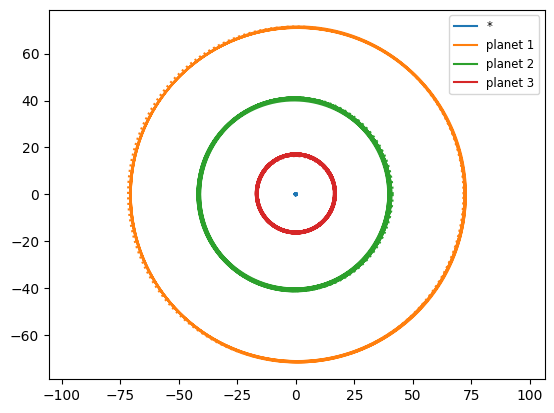

In [10]:
fig = s.plot()